In [34]:
import os
import time
import shutil
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [35]:
file_path = "./dataset/hmnist_28_28_RGB.csv"
df = pd.read_csv(file_path)

print("First 5 records:\n", df.head())

First 5 records:
    pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183    

In [36]:
Label = df["label"]
Data = df.drop(columns=["label"])

In [37]:
df["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [38]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [ ]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [67]:
classes = {
    0: "nv", 1: "mel", 2: "bkl", 3: "bcc", 4: "akiec", 5: "vasc", 6: "df"
}
df['label'] = df['label'].map(lambda x: classes[x][0] if x in classes else 'unknown')

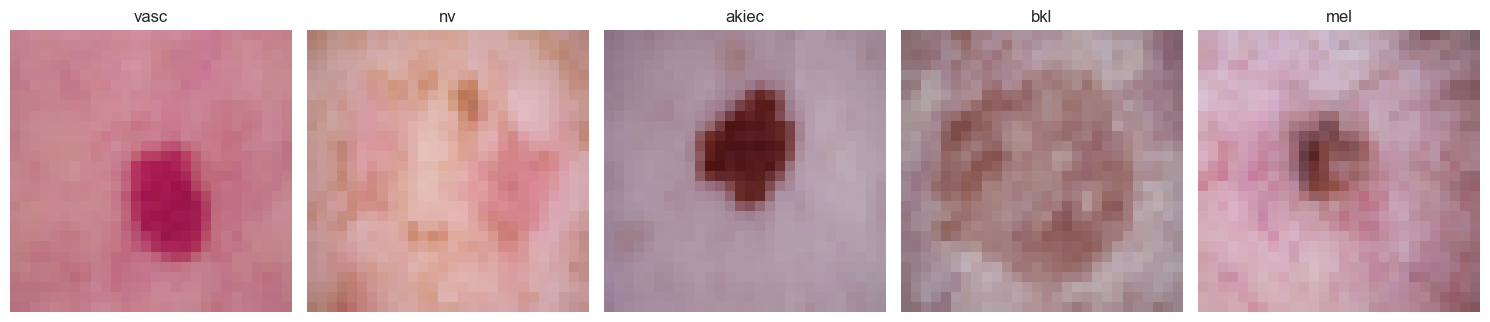

In [ ]:
import matplotlib.pyplot as plt
import random

num_classes_to_display = 5
class_indices = random.sample(range(len(classes)), num_classes_to_display)

fig, axes = plt.subplots(1, num_classes_to_display, figsize=(15, 5))

for i, class_index in enumerate(class_indices):
    class_num = list(classes.keys())[class_index]
    short_name = classes[class_num]
    sample_indices = np.where(Label == class_num)[0]  
    if len(sample_indices) > 0:
        random_index = random.choice(sample_indices)  
        image = Data[random_index] 
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(short_name)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"No {short_name} Data")

plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [22]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
datagen = ImageDataGenerator(rescale=(1./255) ,rotation_range=10 ,zoom_range = 0.1 ,width_shift_range=0.1 ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [24]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [25]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,275,079 (4.86 MB)

 Trainable params: 1,273,671 (4.86 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [26]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")
])

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [28]:
history = model.fit(X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test , y_test) ,
    callbacks=[learning_rate_reduction])

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.2693 - loss: 9.0137 - val_accuracy: 0.4810 - val_loss: 1.4169 - learning_rate: 0.0010
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4921 - loss: 1.3422 - val_accuracy: 0.4657 - val_loss: 1.4078 - learning_rate: 0.0010
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5595 - loss: 1.1832 - val_accuracy: 0.5078 - val_loss: 1.2649 - learning_rate: 0.0010
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6164 - loss: 1.0293 - val_accuracy: 0.6620 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6829 - loss: 0.8564 - val_accuracy: 0.6702 - val_loss: 0.8990 - learning_rate: 0.0010
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6887 - loss: 0.8649 - val_accuracy: 0.7460 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7606 - loss: 0.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i + 1 for i in range(len(tr_acc))]

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

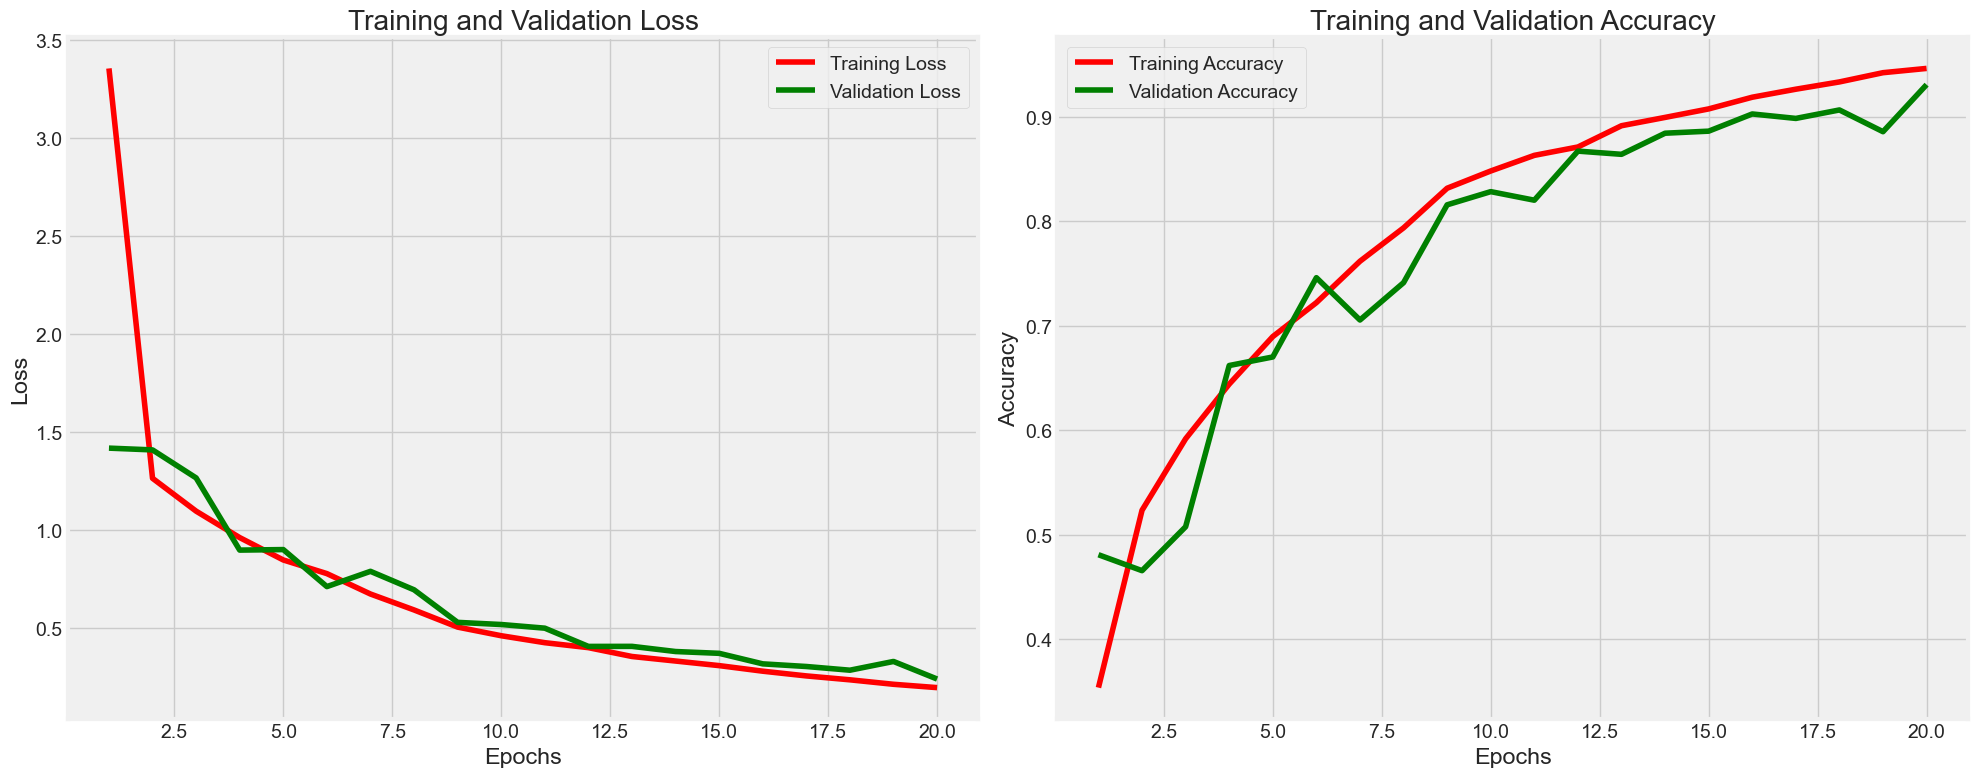

In [30]:
plot_training(history)

In [31]:
train_score = model.evaluate(X_train, y_train, verbose=1)
test_score = model.evaluate(X_test, y_test, verbose=1)

print("\nModel Performance:")
print("=" * 30)
print(f"Train Loss     : {train_score[0]:.4f}")
print(f"Train Accuracy : {train_score[1] * 100:.2f}%")
print("-" * 30)
print(f"Test Loss      : {test_score[0]:.4f}")
print(f"Test Accuracy  : {test_score[1] * 100:.2f}%")


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9536 - loss: 0.1775
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9299 - loss: 0.2397

Model Performance:
Train Loss     : 0.1794
Train Accuracy : 95.32%
------------------------------
Test Loss      : 0.2381
Test Accuracy  : 93.07%


In [32]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [33]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[0, 1, 2, 3, 4, 5, 6]


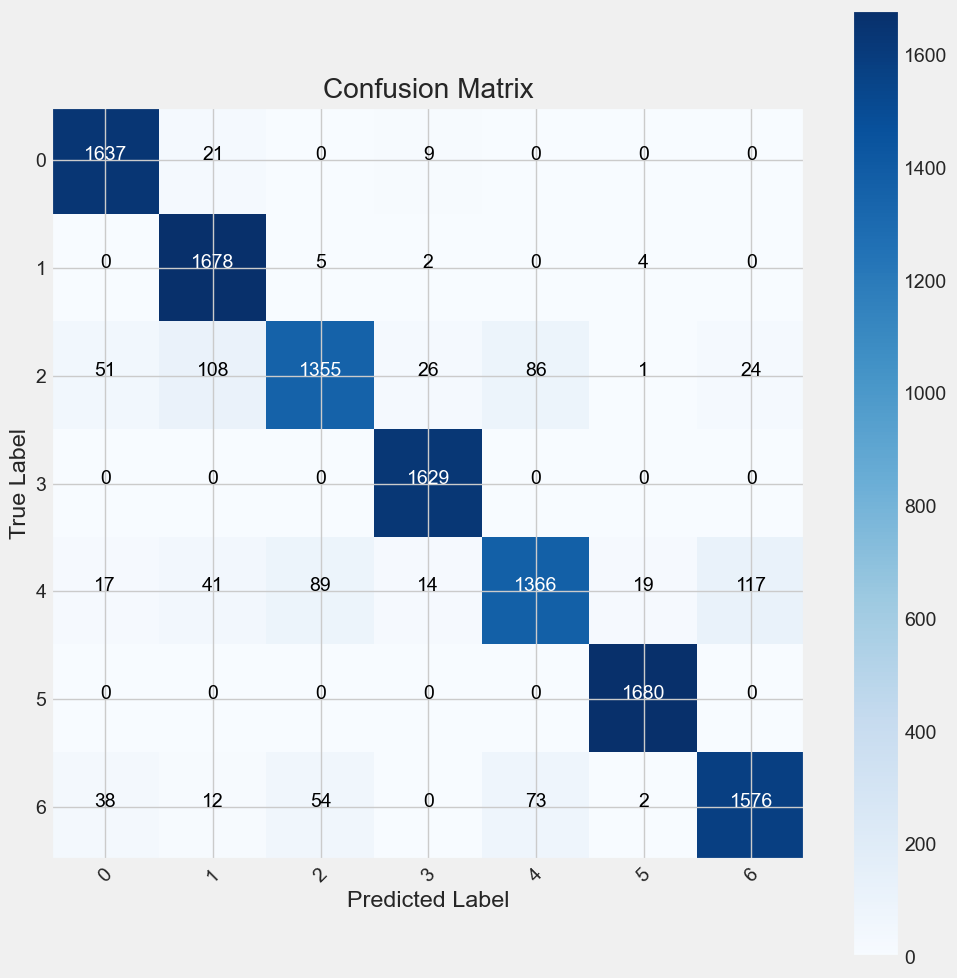

In [34]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


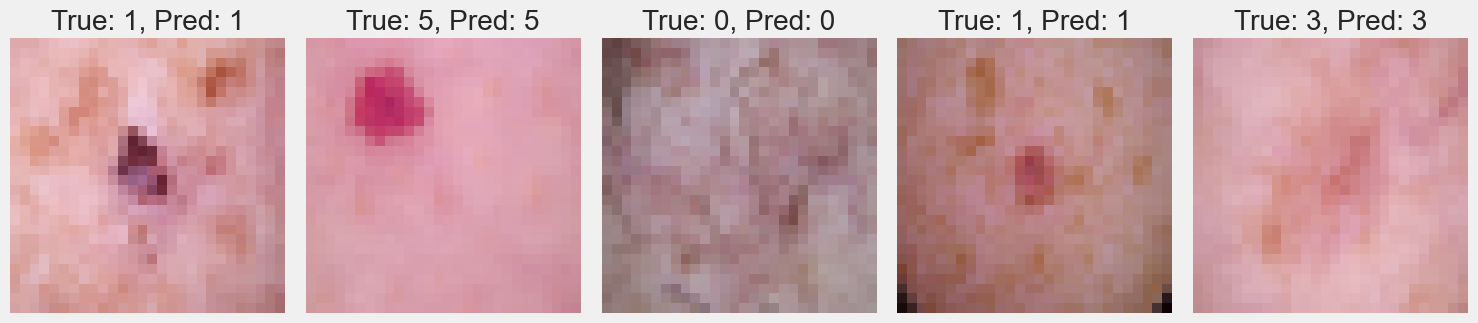

In [37]:
y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

num_samples = 5
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, index in enumerate(random_indices):
  image = X_test[index]
  true_label = y_true[index]
  predicted_label = y_pred[index]

  axes[i].imshow(image)
  axes[i].axis('off')
  axes[i].set_title(f"True: {true_label}, Pred: {predicted_label}")

plt.tight_layout()
plt.show()


In [ ]:
model.save("skin_cancer_model.h5")